In [1]:
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3691, done.
remote: Counting objects: 100% (3691/3691), done.
remote: Compressing objects: 100% (3079/3079), done.
remote: Total 3691 (delta 989), reused 1523 (delta 561), pack-reused 0
Receiving objects: 100% (3691/3691), 48.75 MiB | 11.50 MiB/s, done.
Resolving deltas: 100% (989/989), done.


In [2]:
!sudo apt install -y protobuf-compiler

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.6.1.3-2ubuntu5).
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.


In [3]:
%cd models/research/

/content/models/research


In [4]:
!protoc object_detection/protos/*.proto --python_out=.

In [5]:
!cp object_detection/packages/tf2/setup.py .

In [6]:
!python -m pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/models/research
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 76.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 92.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 KB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 77.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 107.

In [7]:
%cd /content

/content


In [8]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz

--2023-03-03 13:46:51--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 209.85.146.128, 2607:f8b0:4001:c32::80
Connecting to download.tensorflow.org (download.tensorflow.org)|209.85.146.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   172MB/s    in 1.4s    

2023-03-03 13:46:52 (172 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



In [9]:
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz

In [10]:
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data

In [11]:
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops
from object_detection.utils import colab_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util
import cv2 as cv
import pandas as pd
import numpy as np  
import os
import matplotlib.pyplot as plt
import matplotlib
from six import BytesIO
from PIL import Image,ImageDraw,ImageFont
import imageio

%matplotlib inline

In [12]:
def load_image_into_numpyarray(path):
  img_data = tf.io.gfile.GFile(path,'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width , im_height) = image.size
  
  return np.array(image.getdata()).reshape((im_height,im_width,3)).astype(np.uint8)

def plot_detections(image_np,boxes,classes,scores,category_index,figsize=(12,16),image_name=None):
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.98
  )

  if image_name:
    plt.imsave(image_name,image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

In [13]:
images_dir = '/content/images'

In [14]:
print(os.listdir(images_dir))

['c84d98c41d6118ced6b7b0f6183d7e98.jpg', 'a88e71d7289ff600874266b0eb9f4092--license-plates-frames.jpg', 'dsc01518.jpg', '0e14a4190de442ad4a3153462cd514a5--plates-supercars.jpg', '2d8cc9304b091db55e186f576a28fdeb--vanity-plate-license-plates.jpg', 'Greennumberplate-640x640(2)(1).jpg', 'EQ6bsC_XsAA_vBX.jpg', '40cc79d36a9e462c02e86d2d70985fbe--thanks-for-sharing-number-plates.jpg', '4cd00ea8465a4a80ccd1c4d847fc851d.jpg', '05c423a1cf51c9de9da777349effc6a1--license-plates.jpg', '6C5d4BKpomDg_udS.jpg']


In [15]:
train_images_dir = images_dir
train_images_np = []

for images in os.listdir(train_images_dir):
  image_path = os.path.join(train_images_dir,images)
  train_images_np.append(load_image_into_numpyarray(image_path))

In [16]:
gt_boxes = []

colab_utils.annotate(train_images_np,box_storage_pointer=gt_boxes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [17]:
class_id = 1
num_classes = 1
category_index = {class_id : {'id':class_id , 'name':'name_plate'}}


'''
category_index = {1: {'id':1 , 'name':"drink can"},
                  2: {'id':2 ,  'name':'aluminium_foil'}}
'''             

'\ncategory_index = {1: {\'id\':1 , \'name\':"drink can"},\n                  2: {\'id\':2 ,  \'name\':\'aluminium_foil\'}}\n'

In [18]:
print(gt_boxes)

[array([[0.64275   , 0.2578125 , 0.72108333, 0.4421875 ]]), array([[0.71441667, 0.296875  , 0.79108333, 0.6578125 ]]), array([[0.33941667, 0.275     , 0.67941667, 0.775     ]]), array([[0.58608333, 0.2984375 , 0.62108333, 0.440625  ]]), array([[0.27941667, 0.1640625 , 0.64775   , 0.915625  ]]), array([[0.56775  , 0.175    , 0.84775  , 0.7171875]]), array([[0.54108333, 0.5640625 , 0.58608333, 0.6890625 ]]), array([[0.36441667, 0.3046875 , 0.40108333, 0.4       ]]), array([[0.49275   , 0.5203125 , 0.69941667, 0.6796875 ]]), array([[0.48775  , 0.303125 , 0.57775  , 0.6671875]]), array([[0.46275   , 0.39375   , 0.52608333, 0.6       ]])]


In [19]:
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(
    train_images_np, gt_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')

Done prepping data.


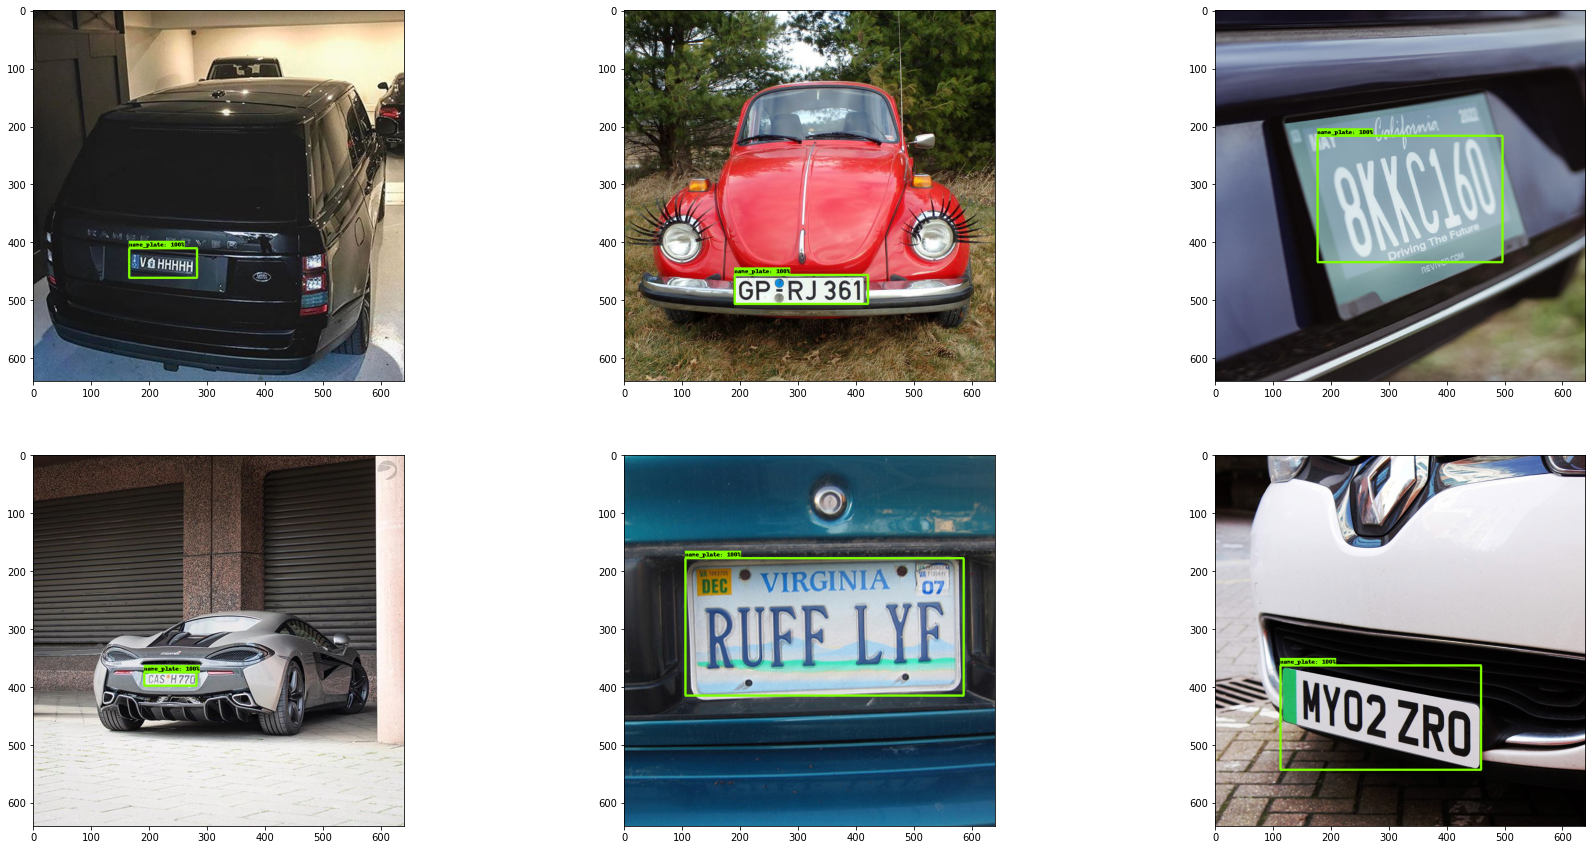

In [20]:
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))
for idx in range(6):
  plt.subplot(2, 3, idx+1)
  plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)
plt.show()

In [21]:
pipeline_config = '/content/models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'

In [22]:
checkpoint_path = "/content/models/research/object_detection/test_data/checkpoint/ckpt-0"

In [23]:
num_classes = 1

configs = config_util.get_configs_from_pipeline_file(pipeline_config)

model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True

detection_model = model_builder.build(model_config=model_config , is_training=True)

In [24]:
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads = detection_model._box_predictor._base_tower_layers_for_heads,
    _box_prediction_head=detection_model._box_predictor._box_prediction_head
)

fake_model = tf.compat.v2.train.Checkpoint(
    _feature_extractor=detection_model._feature_extractor,
    _box_predictor=fake_box_predictor
)

ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

In [25]:
output_directory = '/content/trained_model'
output_checkpoint_dir = os.path.join(output_directory, 'checkpoint')

In [26]:
exported_ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt_manager = tf.train.CheckpointManager(
    exported_ckpt, output_checkpoint_dir, max_to_keep=1)

In [27]:
image,shapes = detection_model.preprocess(tf.zeros([1,640,640,3]))
prediction_dict = detection_model.predict(image,shapes)
_ = detection_model.postprocess(prediction_dict,shapes)

In [28]:
for var in detection_model.trainable_variables:
  print(var.name)

WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/kernel:0
WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/bias:0
WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/kernel:0
WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/bias:0
WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/kernel:0
WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/BatchNorm/feature_0/gamma:0
WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/BatchNorm/feature_0/beta:0
WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_1/kernel:0
WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_1/BatchNorm/feature_0/gamma:0
WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_1/BatchNorm/feature_0/beta:0
WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_2/kernel:0
WeightSharedConvolutional

In [29]:
prefixes_to_train = [
    'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
    'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead'
]
to_fine_tune = []

for var in detection_model.trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

In [30]:
import random
batch_size = 4
learning_rate = 0.01
num_batches = 200

def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


batch 0 of 200, loss=2.025457
batch 10 of 200, loss=4.3341303
batch 20 of 200, loss=2.0075274
batch 30 of 200, loss=0.83629024
batch 40 of 200, loss=0.8731979
batch 50 of 200, loss=0.20672366
batch 60 of 200, loss=0.29567766
batch 70 of 200, loss=0.312682
batch 80 of 200, loss=0.18203092
batch 90 of 200, loss=0.22852635
batch 100 of 200, loss=0.083898984
batch 110 of 200, loss=0.11253364
batch 120 of 200, loss=0.056256197
batch 130 of 200, loss=0.037556667
batch 140 of 200, loss=0.038035557
batch 150 of 200, loss=0.015498211
batch 160 of 200, loss=0.021951262
batch 170 of 200, loss=0.013933574
batch 180 of 200, loss=0.013464077
batch 190 of 200, loss=0.014786319
Done fine-tuning!


checkpoint saved


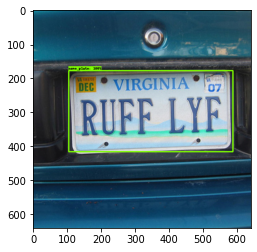

In [31]:
import cv2 as cv

test_image_dir = "/content/test"
test_images_np = []
for images in os.listdir(test_image_dir):
  image_path = os.path.join(test_image_dir, images)
  test_images_np.append(np.expand_dims(
      load_image_into_numpyarray(image_path), axis=0))

# Again, uncomment this decorator if you want to run inference eagerly
@tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  detections = detect(input_tensor)

  plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(30, 20))
  

  ckpt_manager.save()
  print("checkpoint saved")
  #plt.savefig('file.png',dpi=300)
  
  #cv.imwrite(os.path.join(),plate)


In [32]:
from PIL import Image

input_tensor = tf.convert_to_tensor(test_images_np[0],tf.float32)
detection = detect(input_tensor)


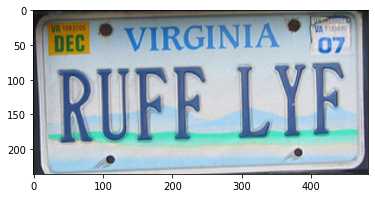

In [33]:
bbox = np.array(detection['detection_boxes'][0][0])*640

img_data = tf.io.gfile.GFile("/content/test/2d8cc9304b091db55e186f576a28fdeb--vanity-plate-license-plates.jpg",'rb').read()
image = Image.open(BytesIO(img_data))
im = tf.image.crop_to_bounding_box(image , int(bbox[0]) , int(bbox[1]) , int(bbox[2]-bbox[0]) , int(bbox[3]-bbox[1]))

plt.imshow(im)
plt.savefig("file",dpi=300)

In [34]:
!python "/content/models/research/object_detection/export_tflite_graph_tf2.py" \
  --pipeline_config_path="/content/models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config" \
  --trained_checkpoint_dir="/content/trained_model/checkpoint" \
  --output_directory="/content/trained_model/tflite"

2023-03-03 13:52:37.085623: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2023-03-03 13:52:37.085730: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2023-03-03 13:52:37.085751: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2023-03-03 13:52:40.378670: W tensorflow/core/common_runt

In [35]:
tflite_model_path = "/content/trained_model/model.tflite"
converter = tf.lite.TFLiteConverter.from_saved_model("/content/trained_model/tflite/saved_model")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open (tflite_model_path , 'wb') as f:
  f.write(tflite_model)

In [ ]:
# change num_class in .config file of the selected model for the above block of code to work